In [196]:
import os
os.environ["OMP_NUM_THREADS"] = "5"

# importing required libraries
import matplotlib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer, silhouette_visualizer
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import silhouette_score, silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import pyvista as pv
import vtk
import os
from vtk import vtkStructuredPoints
from skimage import io, transform
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import mplcyberpunk

from matplotlib.patches import Patch

### Preprocessing

In [197]:
#Read the dataset
df = pd.read_csv('ProfessionalPlayersDataset-13_3.txt', sep=',', encoding='utf-8', low_memory=False)
df.head(10)

gameId  team     summoner region champion  timestamp  \
0  EUW1_6272362521  Blue  anonymous 2   euw1   Akshan   0.000000   
1  EUW1_6272362521  Blue  anonymous 2   euw1   Akshan   1.000300   
2  EUW1_6272362521  Blue  anonymous 2   euw1   Akshan   2.000733   
3  EUW1_6272362521  Blue  anonymous 2   euw1   Akshan   1.932467   
4  EUW1_6272362521  Blue  anonymous 2   euw1   Akshan   3.001000   
5  EUW1_6272362521  Blue  anonymous 2   euw1   Akshan   2.325483   
6  EUW1_6272362521  Blue  anonymous 2   euw1   Akshan   2.815933   
7  EUW1_6272362521  Blue  anonymous 2   euw1   Akshan   4.001267   
8  EUW1_6272362521  Blue  anonymous 2   euw1   Akshan   3.368717   
9  EUW1_6272362521  Blue  anonymous 2   euw1   Akshan   5.001650   

   coordinate_x  coordinate_y  level  minionsKilled  ...  \
0         554.0         581.0    1.0            0.0  ...   
1        3177.0        8848.0    1.0            0.0  ...   
2        2665.0       13301.0    1.0            2.0  ...   
3           NaN           NaN    NaN            NaN  ...   
4        3352.0       13461.0    3.0           14.0  ...   
5           NaN           NaN    NaN            NaN  ...   
6           NaN           NaN    NaN            NaN  ...   
7        2711.0       13268.0    4.0           24.0  ...   
8           NaN           NaN    NaN            NaN  ...   
9        2298.0       13344.0    5.0           35.0  ...   

   trueDamageDoneToChampions  trueDamageTaken  victory     eventType  \
0                        0.0              0.0    False           NaN   
1                        0.0              0.0    False           NaN   
2                        0.0              0.0    False           NaN   
3                        NaN              NaN    False  SkillLevelUp   
4                        0.0              0.0    False           NaN   
5                        NaN              NaN    False  SkillLevelUp   
6                        NaN              NaN    False  SkillLevelUp   
7                        0.0              0.0    False           NaN   
8                        NaN              NaN    False  SkillLevelUp   
9                      150.0              0.0    False           NaN   

   skillSlot  buildingType  lane  monster  itemName  role  
0        NaN           NaN   NaN      NaN       NaN   TOP  
1        NaN           NaN   NaN      NaN       NaN   TOP  
2        NaN           NaN   NaN      NaN       NaN   TOP  
3        1.0           NaN   NaN      NaN       NaN   TOP  
4        NaN           NaN   NaN      NaN       NaN   TOP  
5        3.0           NaN   NaN      NaN       NaN   TOP  
6        1.0           NaN   NaN      NaN       NaN   TOP  
7        NaN           NaN   NaN      NaN       NaN   TOP  
8        3.0           NaN   NaN      NaN       NaN   TOP  
9        NaN           NaN   NaN      NaN       NaN   TOP  

[10 rows x 55 columns]

In [198]:
df.shape

(392071, 55)

In [199]:
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
392066    False
392067    False
392068    False
392069    False
392070    False
Length: 392071, dtype: bool

In [200]:
df.isnull().sum()

gameId                                0
team                                  0
summoner                              0
region                                0
champion                              0
timestamp                             0
coordinate_x                     174453
coordinate_y                     174453
level                            261168
minionsKilled                    261168
jungleMinionsKilled              261168
currentGold                      261168
goldPerSecond                    261168
totalGold                        261168
xp                               261168
abilityPower                     261168
armor                            261168
armorPen                         261168
armorPenPercent                  261168
attackDamage                     261168
attackSpeed                      261168
ccReduction                      261168
health                           261168
healthMax                        261168
healthRegen                      261168


In [201]:
#Filter where role is "JUNGLE" and eventType is "Death"
jungler_deaths = df[(df["role"] == "JUNGLE") & (df["eventType"] == "Death")]

In [202]:
jungler_deaths.shape

(4255, 55)

In [203]:
jungler_deaths.isnull().sum()

gameId                              0
team                                0
summoner                            0
region                              0
champion                            0
timestamp                           0
coordinate_x                        0
coordinate_y                        0
level                            4255
minionsKilled                    4255
jungleMinionsKilled              4255
currentGold                      4255
goldPerSecond                    4255
totalGold                        4255
xp                               4255
abilityPower                     4255
armor                            4255
armorPen                         4255
armorPenPercent                  4255
attackDamage                     4255
attackSpeed                      4255
ccReduction                      4255
health                           4255
healthMax                        4255
healthRegen                      4255
lifesteal                        4255
magicPen    

### Clustering Red Team Victory : 

In [204]:
redSidevictory_df = jungler_deaths[(jungler_deaths["team"] == "Red") & (jungler_deaths["victory"] == True)]
redSidevictory_df

gameId team      summoner region champion  timestamp  \
6038    EUW1_6272468587  Red  anonymous 24   euw1   LeeSin   5.124400   
6041    EUW1_6272468587  Red  anonymous 24   euw1   LeeSin   6.737800   
6221    EUW1_6272349243  Red  anonymous 24   euw1   LeeSin   7.901383   
6226    EUW1_6272349243  Red  anonymous 24   euw1   LeeSin  10.258183   
6253    EUW1_6272349243  Red  anonymous 24   euw1   LeeSin  23.224517   
...                 ...  ...           ...    ...      ...        ...   
275607    KR_6376002673  Red  anonymous 48     kr   Gragas  22.257083   
275614    KR_6376002673  Red  anonymous 48     kr   Gragas  25.482650   
275648    KR_6375973806  Red  anonymous 48     kr   Gragas  12.092683   
275750    KR_6376019501  Red  anonymous 49     kr   Gragas  12.166683   
275757    KR_6376019501  Red  anonymous 49     kr   Gragas  14.189017   

        coordinate_x  coordinate_y  level  minionsKilled  ...  \
6038          7396.0        6838.0    NaN            NaN  ...   
6041         10140.0        2505.0    NaN            NaN  ...   
6221          4114.0        7822.0    NaN            NaN  ...   
6226          5128.0        3384.0    NaN            NaN  ...   
6253          5090.0        9540.0    NaN            NaN  ...   
...              ...           ...    ...            ...  ...   
275607        6048.0        5969.0    NaN            NaN  ...   
275614        6742.0        4329.0    NaN            NaN  ...   
275648        4159.0       10322.0    NaN            NaN  ...   
275750        5575.0        8675.0    NaN            NaN  ...   
275757        8387.0        5417.0    NaN            NaN  ...   

        trueDamageDoneToChampions  trueDamageTaken  victory  eventType  \
6038                          NaN              NaN     True      Death   
6041                          NaN              NaN     True      Death   
6221                          NaN              NaN     True      Death   
6226                          NaN              NaN     True      Death   
6253                          NaN              NaN     True      Death   
...                           ...              ...      ...        ...   
275607                        NaN              NaN     True      Death   
275614                        NaN              NaN     True      Death   
275648                        NaN              NaN     True      Death   
275750                        NaN              NaN     True      Death   
275757                        NaN              NaN     True      Death   

        skillSlot  buildingType  lane  monster  itemName    role  
6038          NaN           NaN   NaN      NaN       NaN  JUNGLE  
6041          NaN           NaN   NaN      NaN       NaN  JUNGLE  
6221          NaN           NaN   NaN      NaN       NaN  JUNGLE  
6226          NaN           NaN   NaN      NaN       NaN  JUNGLE  
6253          NaN           NaN   NaN      NaN       NaN  JUNGLE  
...           ...           ...   ...      ...       ...     ...  
275607        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275614        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275648        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275750        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275757        NaN           NaN   NaN      NaN       NaN  JUNGLE  

[1118 rows x 55 columns]

In [205]:
profiling_df_red_victory = jungler_deaths[(jungler_deaths["team"] == "Red") & (jungler_deaths["victory"] == True)].copy()

Find the best kmeans and silhouette scores : 

K = 2, Silhouette Score = 0.3065
K = 3, Silhouette Score = 0.3186
K = 4, Silhouette Score = 0.3045
K = 5, Silhouette Score = 0.2846
K = 6, Silhouette Score = 0.2878
K = 7, Silhouette Score = 0.2818
K = 8, Silhouette Score = 0.2780
K = 9, Silhouette Score = 0.2718
K = 10, Silhouette Score = 0.2793
K = 11, Silhouette Score = 0.2728
K = 12, Silhouette Score = 0.2660
K = 13, Silhouette Score = 0.2695
K = 14, Silhouette Score = 0.2633
K = 15, Silhouette Score = 0.2648
K = 16, Silhouette Score = 0.2616
K = 17, Silhouette Score = 0.2615
K = 18, Silhouette Score = 0.2670
K = 19, Silhouette Score = 0.2641
K = 20, Silhouette Score = 0.2612
K = 21, Silhouette Score = 0.2593
K = 22, Silhouette Score = 0.2599
K = 23, Silhouette Score = 0.2635
K = 24, Silhouette Score = 0.2689


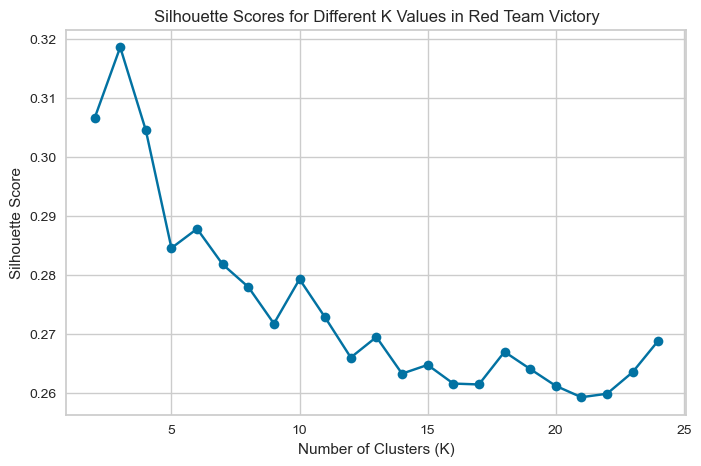

Optimal number of clusters (K) in Red Team Victory = 3, with Silhouette Score = 0.3186


In [206]:
features = ['coordinate_x', 'coordinate_y', 'timestamp']
X_raw = profiling_df_red_victory[features]

# Data Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# Test multiple K values and calculate Silhouette Scores
silhouette_scores = []
K_range = range(2, 25)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)
    print(f'K = {k}, Silhouette Score = {score:.4f}')

# Plot the Silhouette Scores for each K
plt.figure(figsize=(8,5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different K Values in Red Team Victory')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Find the Best K Value
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
best_score = max(silhouette_scores)
print(f'Optimal number of clusters (K) in Red Team Victory = {best_k}, with Silhouette Score = {best_score:.4f}')

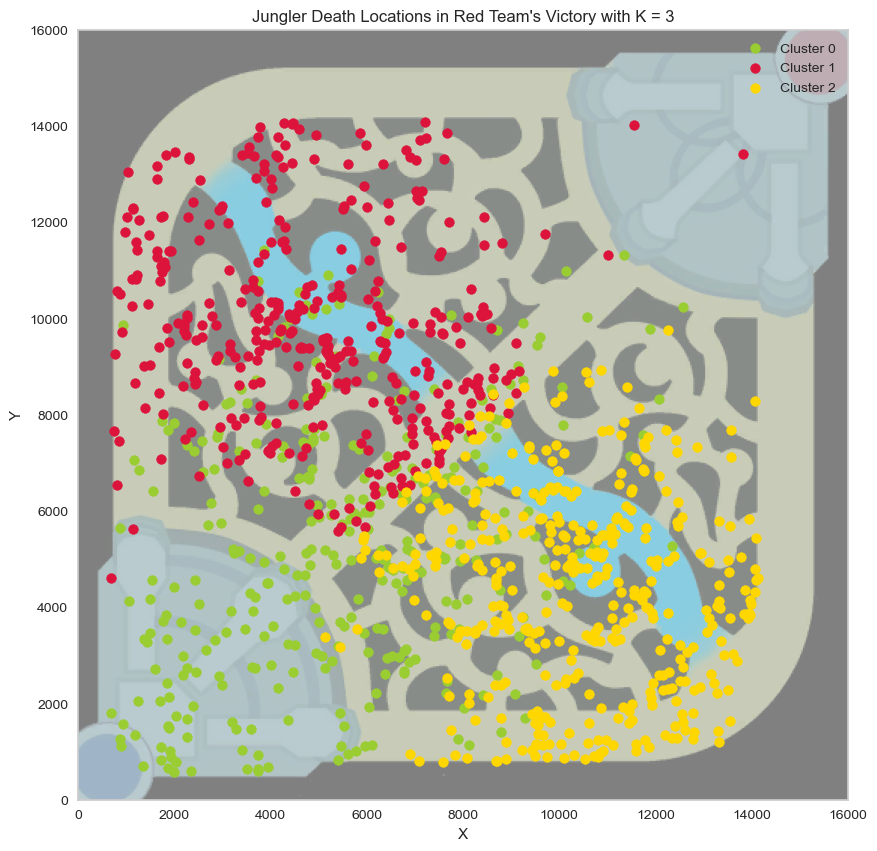

In [207]:
kmeans_best = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10)
profiling_df_red_victory['cluster'] = kmeans_best.fit_predict(X)

# Visualize clustering on map background
plt.figure(figsize=(10,10))

# Load the background map image (summoner's rift)
img = plt.imread('map11.png')  # This is the file you uploaded
plt.imshow(img, extent=[0, 16000, 0, 16000], alpha=0.5)

# Cluster colors (you can modify if needed)
colors = ['yellowgreen', 'crimson', 'gold', 'cornflowerblue', 'purple', 'orange', 'cyan', 'magenta']

# Scatter plot for each cluster
for cluster_num in range(best_k):
    subset = profiling_df_red_victory[profiling_df_red_victory['cluster'] == cluster_num]
    plt.scatter(subset['coordinate_x'], subset['coordinate_y'],
                s=50, color=colors[cluster_num], label=f'Cluster {cluster_num}')

plt.title(f"Jungler Death Locations in Red Team's Victory with K = {best_k}")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(False)
plt.show()

In [208]:
profiling_df_red_victory['timestamp'].describe()

count    1118.000000
mean       15.699426
std         8.004133
min         0.756083
25%         9.199871
50%        15.479933
75%        21.495521
max        40.960933
Name: timestamp, dtype: float64

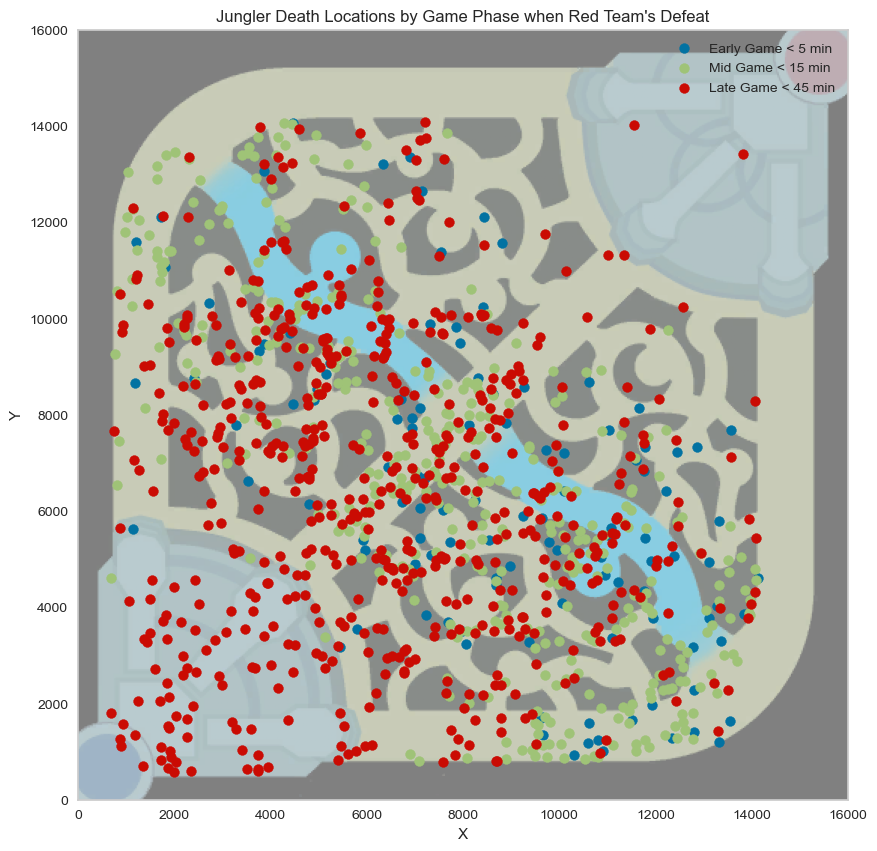

In [209]:
# Set the time range
bins = [0, 5, 15, 45]
labels = ['Early Game < 5 min', 'Mid Game < 15 min', 'Late Game < 45 min']

profiling_df_red_victory['time_phase'] = pd.cut(profiling_df_red_victory['timestamp'], bins=bins, labels=labels, right=True)

# 繪圖：分不同時間階段畫出死亡點
plt.figure(figsize=(10,10))
plt.imshow(img, extent=[0, 16000, 0, 16000], alpha=0.5)

for phase in labels:
    subset = profiling_df_red_victory[profiling_df_red_victory['time_phase'] == phase]
    plt.scatter(subset['coordinate_x'], subset['coordinate_y'], s=50, label=f'{phase}')

plt.title(f"Jungler Death Locations by Game Phase when Red Team's Defeat")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(False)
plt.show()

### Clustering Red Team Defeat

In [210]:
redSideDefeat_df = jungler_deaths[(jungler_deaths["team"] == "Red") & (jungler_deaths["victory"] == False)]
redSideDefeat_df

gameId team      summoner region champion  timestamp  \
5915    EUW1_6272528116  Red  anonymous 24   euw1   LeeSin   5.672050   
5938    EUW1_6272528116  Red  anonymous 24   euw1   LeeSin  17.020000   
5946    EUW1_6272528116  Red  anonymous 24   euw1   LeeSin  21.701117   
5951    EUW1_6272528116  Red  anonymous 24   euw1   LeeSin  23.496983   
5958    EUW1_6272528116  Red  anonymous 24   euw1   LeeSin  27.062767   
...                 ...  ...           ...    ...      ...        ...   
275670    KR_6375903925  Red  anonymous 48     kr    Elise   4.274650   
275702    KR_6375903925  Red  anonymous 48     kr    Elise  20.639133   
275711    KR_6375903925  Red  anonymous 48     kr    Elise  26.279650   
275716    KR_6375903925  Red  anonymous 48     kr    Elise  29.629633   
275722    KR_6375903925  Red  anonymous 48     kr    Elise  32.611683   

        coordinate_x  coordinate_y  level  minionsKilled  ...  \
5915          8286.0        7654.0    NaN            NaN  ...   
5938         10048.0        8002.0    NaN            NaN  ...   
5946          6100.0       11267.0    NaN            NaN  ...   
5951          9475.0        8919.0    NaN            NaN  ...   
5958         11804.0       13243.0    NaN            NaN  ...   
...              ...           ...    ...            ...  ...   
275670        7985.0        3502.0    NaN            NaN  ...   
275702        4859.0       10824.0    NaN            NaN  ...   
275711        1722.0        9788.0    NaN            NaN  ...   
275716        3384.0       11610.0    NaN            NaN  ...   
275722        6544.0       14078.0    NaN            NaN  ...   

        trueDamageDoneToChampions  trueDamageTaken  victory  eventType  \
5915                          NaN              NaN    False      Death   
5938                          NaN              NaN    False      Death   
5946                          NaN              NaN    False      Death   
5951                          NaN              NaN    False      Death   
5958                          NaN              NaN    False      Death   
...                           ...              ...      ...        ...   
275670                        NaN              NaN    False      Death   
275702                        NaN              NaN    False      Death   
275711                        NaN              NaN    False      Death   
275716                        NaN              NaN    False      Death   
275722                        NaN              NaN    False      Death   

        skillSlot  buildingType  lane  monster  itemName    role  
5915          NaN           NaN   NaN      NaN       NaN  JUNGLE  
5938          NaN           NaN   NaN      NaN       NaN  JUNGLE  
5946          NaN           NaN   NaN      NaN       NaN  JUNGLE  
5951          NaN           NaN   NaN      NaN       NaN  JUNGLE  
5958          NaN           NaN   NaN      NaN       NaN  JUNGLE  
...           ...           ...   ...      ...       ...     ...  
275670        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275702        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275711        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275716        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275722        NaN           NaN   NaN      NaN       NaN  JUNGLE  

[1241 rows x 55 columns]

In [211]:
profiling_df_red_defeat = jungler_deaths[(jungler_deaths["team"] == "Red") & (jungler_deaths["victory"] == False)].copy()

Find the best kmeans and silhouette scores : 

K = 2, Silhouette Score = 0.2998
K = 3, Silhouette Score = 0.3122
K = 4, Silhouette Score = 0.3063
K = 5, Silhouette Score = 0.2826
K = 6, Silhouette Score = 0.2850
K = 7, Silhouette Score = 0.2851
K = 8, Silhouette Score = 0.2776
K = 9, Silhouette Score = 0.2717
K = 10, Silhouette Score = 0.2543
K = 11, Silhouette Score = 0.2587
K = 12, Silhouette Score = 0.2494
K = 13, Silhouette Score = 0.2519
K = 14, Silhouette Score = 0.2581
K = 15, Silhouette Score = 0.2538
K = 16, Silhouette Score = 0.2553
K = 17, Silhouette Score = 0.2521
K = 18, Silhouette Score = 0.2569
K = 19, Silhouette Score = 0.2606
K = 20, Silhouette Score = 0.2597
K = 21, Silhouette Score = 0.2523
K = 22, Silhouette Score = 0.2603
K = 23, Silhouette Score = 0.2656
K = 24, Silhouette Score = 0.2688


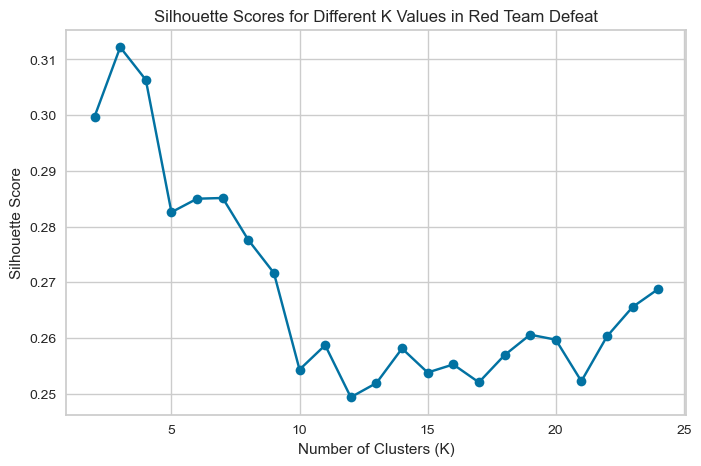

Optimal number of clusters (K) in Red Team Defeat = 3, with Silhouette Score = 0.3122


In [212]:
features = ['coordinate_x', 'coordinate_y', 'timestamp']
X_raw = profiling_df_red_defeat[features]

# Data Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# Test multiple K values and calculate Silhouette Scores
silhouette_scores = []
K_range = range(2, 25)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)
    print(f'K = {k}, Silhouette Score = {score:.4f}')

# Plot the Silhouette Scores for each K
plt.figure(figsize=(8,5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different K Values in Red Team Defeat')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Find the Best K Value
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
best_score = max(silhouette_scores)
print(f'Optimal number of clusters (K) in Red Team Defeat = {best_k}, with Silhouette Score = {best_score:.4f}')

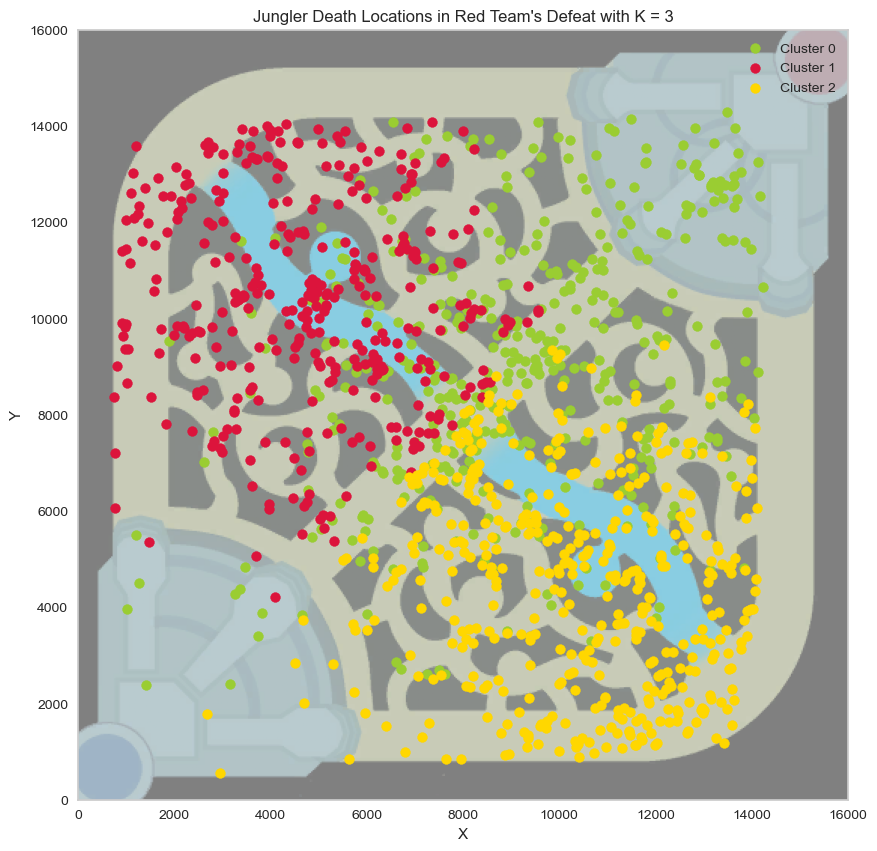

In [213]:
kmeans_best = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10)
profiling_df_red_defeat['cluster'] = kmeans_best.fit_predict(X)

# Visualize clustering on map background
plt.figure(figsize=(10,10))

# Load the background map image (summoner's rift)
img = plt.imread('map11.png')  # This is the file you uploaded
plt.imshow(img, extent=[0, 16000, 0, 16000], alpha=0.5)

# Cluster colors (you can modify if needed)
colors = ['yellowgreen', 'crimson', 'gold', 'cornflowerblue', 'purple', 'orange', 'cyan', 'magenta']

# Scatter plot for each cluster
for cluster_num in range(best_k):
    subset = profiling_df_red_defeat[profiling_df_red_defeat['cluster'] == cluster_num]
    plt.scatter(subset['coordinate_x'], subset['coordinate_y'],
                s=50, color=colors[cluster_num], label=f'Cluster {cluster_num}')

plt.title(f"Jungler Death Locations in Red Team's Defeat with K = {best_k}")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(False)
plt.show()

### Clustering Blue Team Victory : 

In [214]:
blueSidevictory_df = jungler_deaths[(jungler_deaths["team"] == "Blue") & (jungler_deaths["victory"] == True)]
blueSidevictory_df

gameId  team      summoner region champion  timestamp  \
6199    EUW1_6272384642  Blue  anonymous 24   euw1    Elise  20.334733   
7176    EUW1_6274092862  Blue  anonymous 26   euw1   Maokai   6.716617   
7193    EUW1_6274092862  Blue  anonymous 26   euw1   Maokai  14.921200   
7212    EUW1_6274092862  Blue  anonymous 26   euw1   Maokai  22.328617   
7222    EUW1_6274092862  Blue  anonymous 26   euw1   Maokai  25.689900   
...                 ...   ...           ...    ...      ...        ...   
274945  EUW1_6289253359  Blue  anonymous 30   euw1   Gragas  17.550000   
274953  EUW1_6289253359  Blue  anonymous 30   euw1   Gragas  20.241800   
275275   NA1_4584642620  Blue  anonymous 37    na1    Sylas   6.681717   
275292   NA1_4584642620  Blue  anonymous 37    na1    Sylas  14.535800   
275301   NA1_4584642620  Blue  anonymous 37    na1    Sylas  17.230867   

        coordinate_x  coordinate_y  level  minionsKilled  ...  \
6199         11330.0       10690.0    NaN            NaN  ...   
7176         11645.0        4565.0    NaN            NaN  ...   
7193          9965.0        4349.0    NaN            NaN  ...   
7212         11123.0       10651.0    NaN            NaN  ...   
7222         13565.0        8599.0    NaN            NaN  ...   
...              ...           ...    ...            ...  ...   
274945        8938.0       12870.0    NaN            NaN  ...   
274953       13882.0       13032.0    NaN            NaN  ...   
275275       10547.0        5428.0    NaN            NaN  ...   
275292        6292.0       10252.0    NaN            NaN  ...   
275301       13350.0        7182.0    NaN            NaN  ...   

        trueDamageDoneToChampions  trueDamageTaken  victory  eventType  \
6199                          NaN              NaN     True      Death   
7176                          NaN              NaN     True      Death   
7193                          NaN              NaN     True      Death   
7212                          NaN              NaN     True      Death   
7222                          NaN              NaN     True      Death   
...                           ...              ...      ...        ...   
274945                        NaN              NaN     True      Death   
274953                        NaN              NaN     True      Death   
275275                        NaN              NaN     True      Death   
275292                        NaN              NaN     True      Death   
275301                        NaN              NaN     True      Death   

        skillSlot  buildingType  lane  monster  itemName    role  
6199          NaN           NaN   NaN      NaN       NaN  JUNGLE  
7176          NaN           NaN   NaN      NaN       NaN  JUNGLE  
7193          NaN           NaN   NaN      NaN       NaN  JUNGLE  
7212          NaN           NaN   NaN      NaN       NaN  JUNGLE  
7222          NaN           NaN   NaN      NaN       NaN  JUNGLE  
...           ...           ...   ...      ...       ...     ...  
274945        NaN           NaN   NaN      NaN       NaN  JUNGLE  
274953        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275275        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275292        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275301        NaN           NaN   NaN      NaN       NaN  JUNGLE  

[656 rows x 55 columns]

In [215]:
profiling_df_blue_victory = jungler_deaths[(jungler_deaths["team"] == "Blue") & (jungler_deaths["victory"] == True)].copy()

Find the best kmeans and silhouette scores : 

d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

K = 2, Silhouette Score = 0.3166
K = 3, Silhouette Score = 0.3404
K = 4, Silhouette Score = 0.3232
K = 5, Silhouette Score = 0.2853
K = 6, Silhouette Score = 0.2992
K = 7, Silhouette Score = 0.2911
K = 8, Silhouette Score = 0.2766
K = 9, Silhouette Score = 0.2666
K = 10, Silhouette Score = 0.2634
K = 11, Silhouette Score = 0.2720
K = 12, Silhouette Score = 0.2626


d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

K = 13, Silhouette Score = 0.2584
K = 14, Silhouette Score = 0.2659
K = 15, Silhouette Score = 0.2518
K = 16, Silhouette Score = 0.2547
K = 17, Silhouette Score = 0.2622


d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

K = 18, Silhouette Score = 0.2552
K = 19, Silhouette Score = 0.2589
K = 20, Silhouette Score = 0.2585
K = 21, Silhouette Score = 0.2658
K = 22, Silhouette Score = 0.2626


d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

K = 23, Silhouette Score = 0.2526
K = 24, Silhouette Score = 0.2678


d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


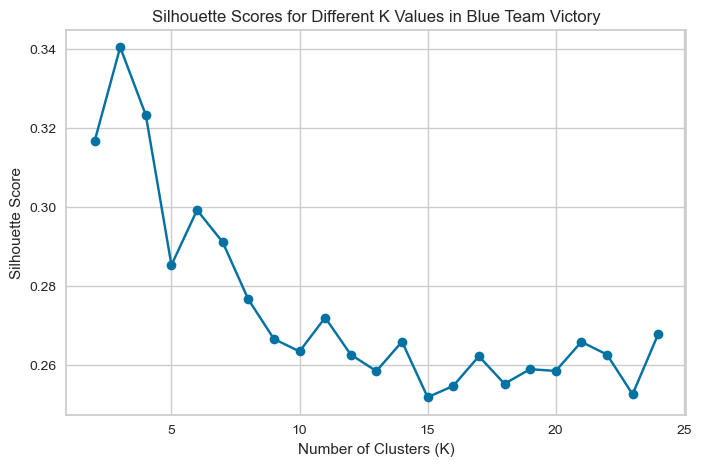

Optimal number of clusters (K) in Blue Team Victory = 3, with Silhouette Score = 0.3404


In [216]:
features = ['coordinate_x', 'coordinate_y', 'timestamp']
X_raw = profiling_df_blue_victory[features]

# Data Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# Test multiple K values and calculate Silhouette Scores
silhouette_scores = []
K_range = range(2, 25)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)
    print(f'K = {k}, Silhouette Score = {score:.4f}')

# Plot the Silhouette Scores for each K
plt.figure(figsize=(8,5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different K Values in Blue Team Victory')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Find the Best K Value
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
best_score = max(silhouette_scores)
print(f'Optimal number of clusters (K) in Blue Team Victory = {best_k}, with Silhouette Score = {best_score:.4f}')

d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


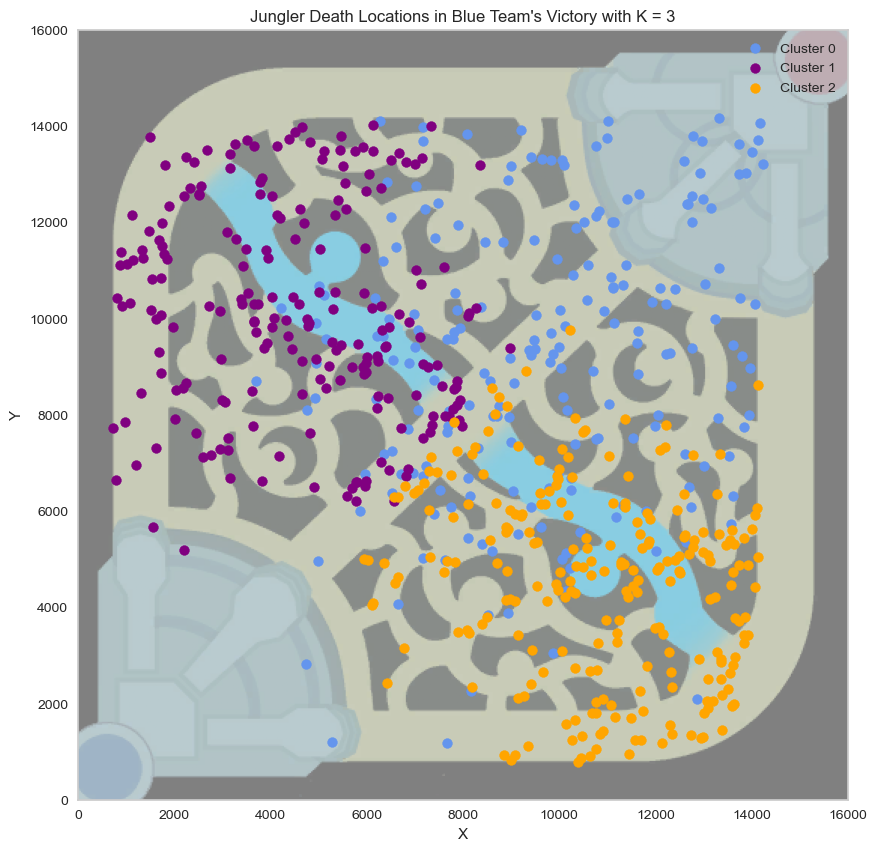

In [217]:
kmeans_best = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10)
profiling_df_blue_victory['cluster'] = kmeans_best.fit_predict(X)

# Visualize clustering on map background
plt.figure(figsize=(10,10))

# Load the background map image (summoner's rift)
img = plt.imread('map11.png')  # This is the file you uploaded
plt.imshow(img, extent=[0, 16000, 0, 16000], alpha=0.5)

# Cluster colors (you can modify if needed)
colors = ['cornflowerblue', 'purple', 'orange', 'cyan', 'magenta']

# Scatter plot for each cluster
for cluster_num in range(best_k):
    subset = profiling_df_blue_victory[profiling_df_blue_victory['cluster'] == cluster_num]
    plt.scatter(subset['coordinate_x'], subset['coordinate_y'],
                s=50, color=colors[cluster_num], label=f'Cluster {cluster_num}')

plt.title(f"Jungler Death Locations in Blue Team's Victory with K = {best_k}")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(False)
plt.show()

### Clustering Blue Team Defeat

In [218]:
blueSideDefeat_df = jungler_deaths[(jungler_deaths["team"] == "Blue") & (jungler_deaths["victory"] == False)]
blueSideDefeat_df

gameId  team      summoner region champion  timestamp  \
6474    EUW1_6270921663  Blue  anonymous 24   euw1   LeeSin   3.296667   
6482    EUW1_6270921663  Blue  anonymous 24   euw1   LeeSin   7.523067   
6489    EUW1_6270921663  Blue  anonymous 24   euw1   LeeSin  11.265733   
6492    EUW1_6270921663  Blue  anonymous 24   euw1   LeeSin  13.005150   
6498    EUW1_6270921663  Blue  anonymous 24   euw1   LeeSin  15.205950   
...                 ...   ...           ...    ...      ...        ...   
275253   NA1_4584979649  Blue  anonymous 35    na1  Trundle  19.274400   
275255   NA1_4584979649  Blue  anonymous 35    na1  Trundle  20.904200   
275359   NA1_4584524732  Blue  anonymous 41    na1    Poppy   6.853167   
275380   NA1_4584524732  Blue  anonymous 41    na1    Poppy  17.374817   
275395   NA1_4584524732  Blue  anonymous 41    na1    Poppy  25.412900   

        coordinate_x  coordinate_y  level  minionsKilled  ...  \
6474          8030.0        5198.0    NaN            NaN  ...   
6482          6387.0        9619.0    NaN            NaN  ...   
6489          4626.0        9854.0    NaN            NaN  ...   
6492         13593.0        3353.0    NaN            NaN  ...   
6498          1855.0        4186.0    NaN            NaN  ...   
...              ...           ...    ...            ...  ...   
275253        3240.0       10649.0    NaN            NaN  ...   
275255        3600.0        8230.0    NaN            NaN  ...   
275359       12331.0        4912.0    NaN            NaN  ...   
275380        6006.0        6468.0    NaN            NaN  ...   
275395        2980.0       11546.0    NaN            NaN  ...   

        trueDamageDoneToChampions  trueDamageTaken  victory  eventType  \
6474                          NaN              NaN    False      Death   
6482                          NaN              NaN    False      Death   
6489                          NaN              NaN    False      Death   
6492                          NaN              NaN    False      Death   
6498                          NaN              NaN    False      Death   
...                           ...              ...      ...        ...   
275253                        NaN              NaN    False      Death   
275255                        NaN              NaN    False      Death   
275359                        NaN              NaN    False      Death   
275380                        NaN              NaN    False      Death   
275395                        NaN              NaN    False      Death   

        skillSlot  buildingType  lane  monster  itemName    role  
6474          NaN           NaN   NaN      NaN       NaN  JUNGLE  
6482          NaN           NaN   NaN      NaN       NaN  JUNGLE  
6489          NaN           NaN   NaN      NaN       NaN  JUNGLE  
6492          NaN           NaN   NaN      NaN       NaN  JUNGLE  
6498          NaN           NaN   NaN      NaN       NaN  JUNGLE  
...           ...           ...   ...      ...       ...     ...  
275253        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275255        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275359        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275380        NaN           NaN   NaN      NaN       NaN  JUNGLE  
275395        NaN           NaN   NaN      NaN       NaN  JUNGLE  

[1240 rows x 55 columns]

In [219]:
profiling_df_blue_defeat = jungler_deaths[(jungler_deaths["team"] == "Blue") & (jungler_deaths["victory"] == False)].copy()

Find the best kmeans and silhouette scores : 

K = 2, Silhouette Score = 0.3102
K = 3, Silhouette Score = 0.3166
K = 4, Silhouette Score = 0.2995
K = 5, Silhouette Score = 0.2893
K = 6, Silhouette Score = 0.2868
K = 7, Silhouette Score = 0.2759
K = 8, Silhouette Score = 0.2701
K = 9, Silhouette Score = 0.2690
K = 10, Silhouette Score = 0.2739
K = 11, Silhouette Score = 0.2617
K = 12, Silhouette Score = 0.2637
K = 13, Silhouette Score = 0.2633
K = 14, Silhouette Score = 0.2530
K = 15, Silhouette Score = 0.2618
K = 16, Silhouette Score = 0.2601
K = 17, Silhouette Score = 0.2556
K = 18, Silhouette Score = 0.2621
K = 19, Silhouette Score = 0.2531
K = 20, Silhouette Score = 0.2540
K = 21, Silhouette Score = 0.2546
K = 22, Silhouette Score = 0.2573
K = 23, Silhouette Score = 0.2637
K = 24, Silhouette Score = 0.2597


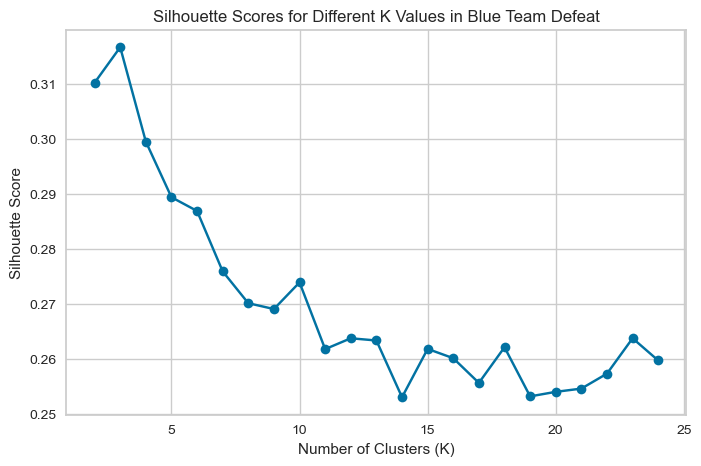

Optimal number of clusters (K) in Blue Team Defeat = 3, with Silhouette Score = 0.3166


In [220]:
features = ['coordinate_x', 'coordinate_y', 'timestamp']
X_raw = profiling_df_blue_defeat[features]

# Data Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# Test multiple K values and calculate Silhouette Scores
silhouette_scores = []
K_range = range(2, 25)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)
    print(f'K = {k}, Silhouette Score = {score:.4f}')

# Plot the Silhouette Scores for each K
plt.figure(figsize=(8,5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different K Values in Blue Team Defeat')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Find the Best K Value
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
best_score = max(silhouette_scores)
print(f'Optimal number of clusters (K) in Blue Team Defeat = {best_k}, with Silhouette Score = {best_score:.4f}')

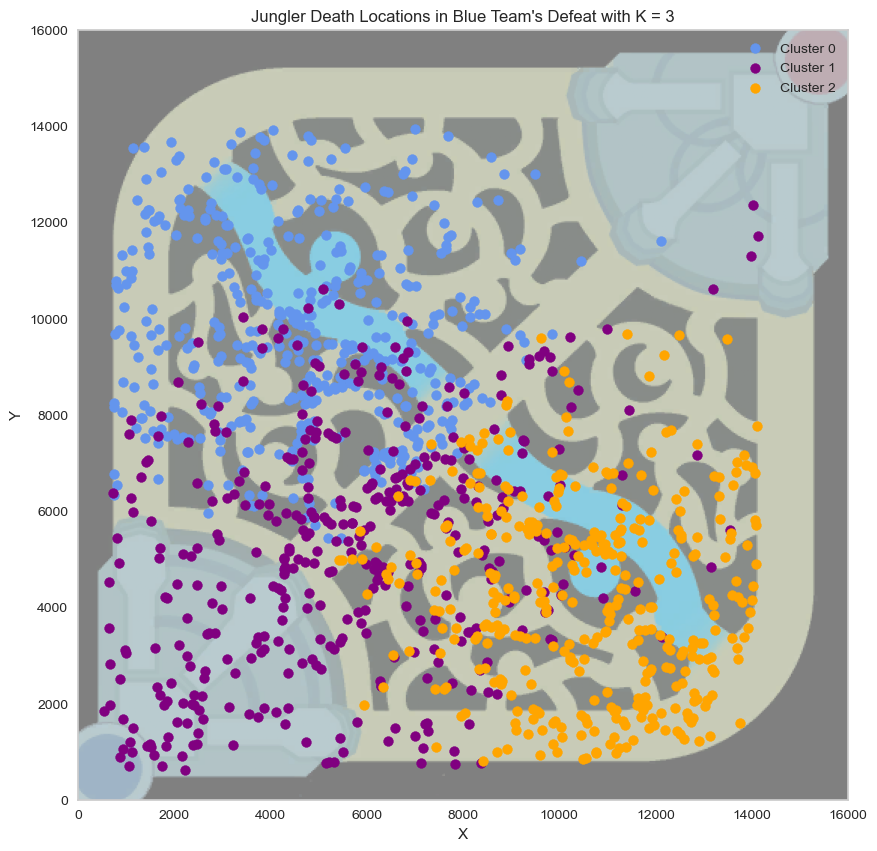

In [221]:
kmeans_best = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10)
profiling_df_blue_defeat['cluster'] = kmeans_best.fit_predict(X)

# Visualize clustering on map background
plt.figure(figsize=(10,10))

# Load the background map image (summoner's rift)
img = plt.imread('map11.png')  # This is the file you uploaded
plt.imshow(img, extent=[0, 16000, 0, 16000], alpha=0.5)

# Cluster colors (you can modify if needed)
colors = ['cornflowerblue', 'purple', 'orange', 'cyan', 'magenta']

# Scatter plot for each cluster
for cluster_num in range(best_k):
    subset = profiling_df_blue_defeat[profiling_df_blue_defeat['cluster'] == cluster_num]
    plt.scatter(subset['coordinate_x'], subset['coordinate_y'],
                s=50, color=colors[cluster_num], label=f'Cluster {cluster_num}')

plt.title(f"Jungler Death Locations in Blue Team's Defeat with K = {best_k}")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(False)
plt.show()

### Conclution :

#### 1.  Clustering Results and Model Performance

In [222]:
data = {
    'Team': ['Red', 'Red', 'Blue', 'Blue'],
    'Result': ['Victory', 'Defeat', 'Victory', 'Defeat'],
    'Best K': [3, 3, 3, 3],
    'Silhouette Score': [0.3186, 0.3122, 0.3404, 0.3166],
    'Death Zone & Clustering Traits': [
        'Deaths are spread out, focused on river and enemy jungle — active playstyle',
        'Deaths concentrated in own jungle — reflects passive play and jungle loss',
        'Strong clustering, balanced distribution — shows proactive map control',
        'Deaths near own jungle and base — defensive posture and suppressed play'
    ]
}

df_summary = pd.DataFrame(data)

# Show DataFrame (e.g., in Jupyter, VS Code, Colab)
pd.set_option('display.max_colwidth', None)
display(df_summary)


Team   Result  Best K  Silhouette Score  \
0   Red  Victory       3            0.3186   
1   Red   Defeat       3            0.3122   
2  Blue  Victory       3            0.3404   
3  Blue   Defeat       3            0.3166   

                                                Death Zone & Clustering Traits  
0  Deaths are spread out, focused on river and enemy jungle — active playstyle  
1    Deaths concentrated in own jungle — reflects passive play and jungle loss  
2       Strong clustering, balanced distribution — shows proactive map control  
3      Deaths near own jungle and base — defensive posture and suppressed play

* In all four scenarios, K = 3 was the optimal choice.
* Silhouette scores ranged between 0.31 and 0.34, indicating reasonable clustering validity.

#### 2. Common Patterns in Victories

* Death locations were more dispersed.
* Deaths occurred across the river, mid lane, and enemy jungle, reflecting proactive gameplay and strong objective control.
* No obvious concentration of deaths near the base or defensive zones, suggesting effective map control.

#### 3. Common Patterns in Defeats

* Deaths were more concentrated in own jungle and around the base defense area.
* Indicates loss of tempo, jungle control failure, or passive play.
* Clusters in defeats showed a defensive pattern, making it easier for the opponent to dominate jungle areas and vision control.

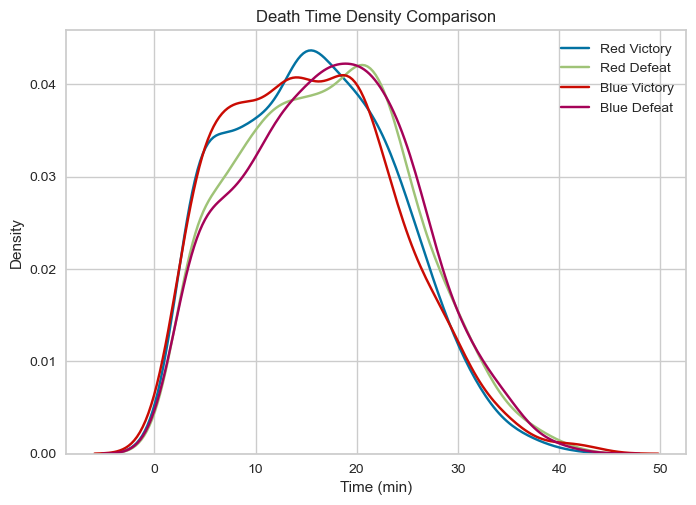

In [223]:
import seaborn as sb

sb.kdeplot(data=profiling_df_red_victory, x='timestamp', label='Red Victory')
sb.kdeplot(data=profiling_df_red_defeat, x='timestamp', label='Red Defeat')
sb.kdeplot(data=profiling_df_blue_victory, x='timestamp', label='Blue Victory')
sb.kdeplot(data=profiling_df_blue_defeat, x='timestamp', label='Blue Defeat')
plt.legend()
plt.title('Death Time Density Comparison')
plt.xlabel('Time (min)')
plt.show()

In [224]:
jungler_deaths['timestamp'].describe()

count    4255.000000
mean       16.469492
std         8.238565
min         0.731083
25%         9.876392
50%        16.269183
75%        22.389800
max        43.047600
Name: timestamp, dtype: float64

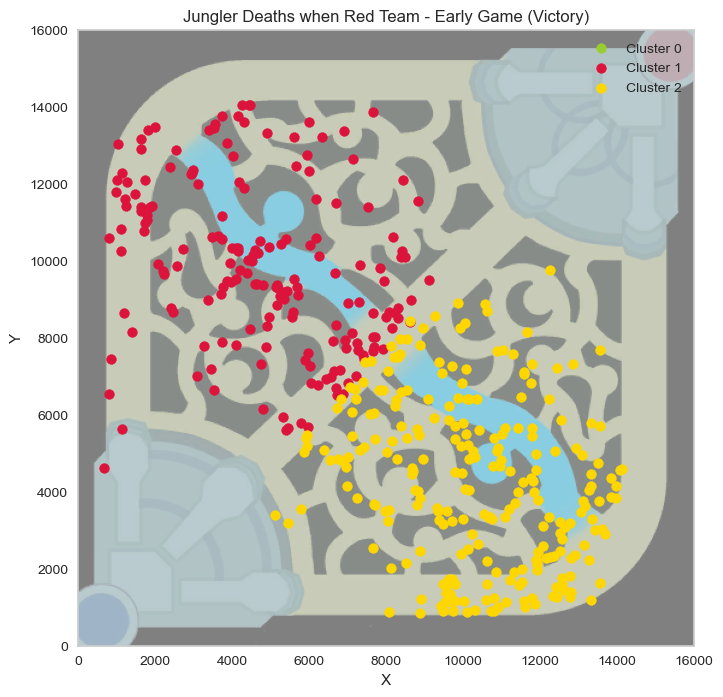

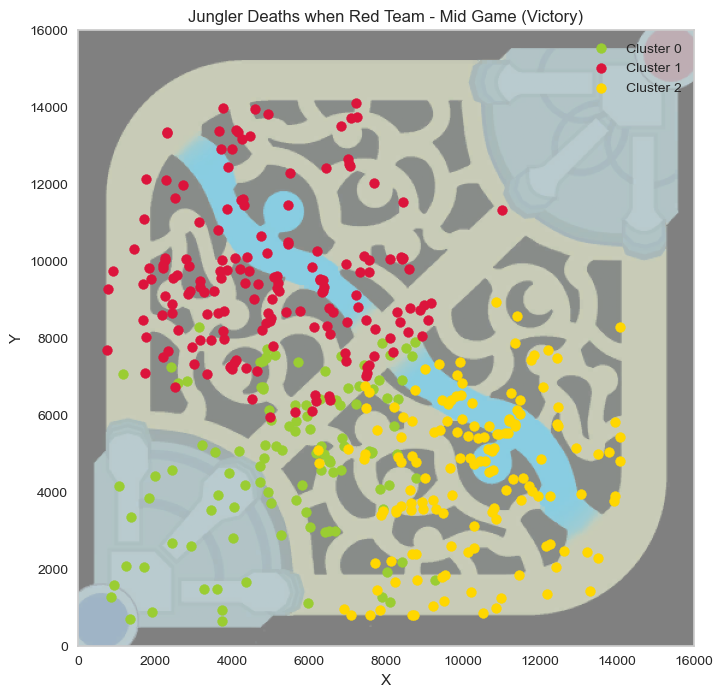

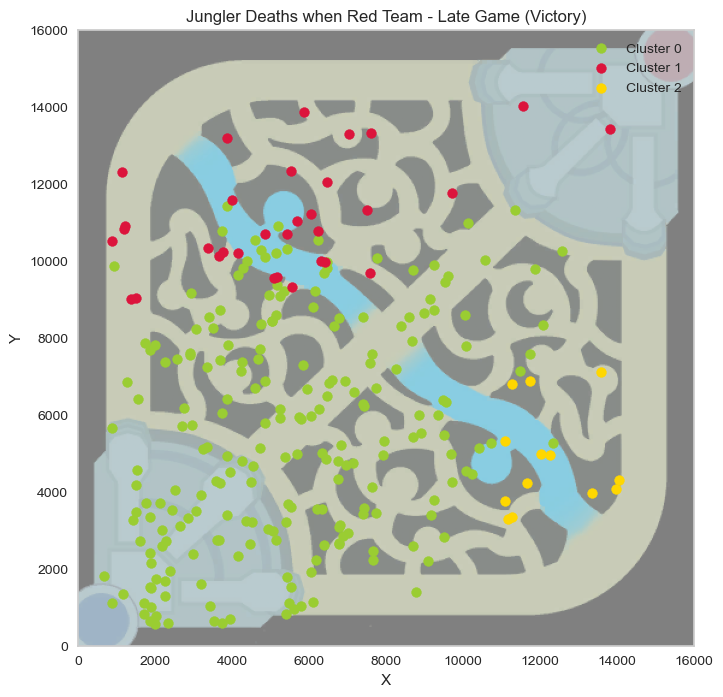

In [225]:
# Define time intervals (in minutess)
bins = [0, 13, 22, 45]
labels = ['Early Game', 'Mid Game', 'Late Game']

# Using existing DataFrame
profiling_df_red_victory['time_phase'] = pd.cut(profiling_df_red_victory['timestamp'], bins=bins, labels=labels, right=True)

# Set cluster colors
colors = ['yellowgreen', 'crimson', 'gold', 'cornflowerblue', 'purple']

# Plot three separate maps (one for each time phase)
for phase in labels:
    plt.figure(figsize=(8,8))
    plt.imshow(img, extent=[0, 16000, 0, 16000], alpha=0.5)

    for cluster_num in range(best_k): 
        subset = profiling_df_red_victory[
            (profiling_df_red_victory['time_phase'] == phase) &
            (profiling_df_red_victory['cluster'] == cluster_num)
        ]
        plt.scatter(subset['coordinate_x'], subset['coordinate_y'],
                    s=50, color=colors[cluster_num], label=f'Cluster {cluster_num}')

    plt.title(f"Jungler Deaths when Red Team - {phase} (Victory)")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(False)
    plt.show()


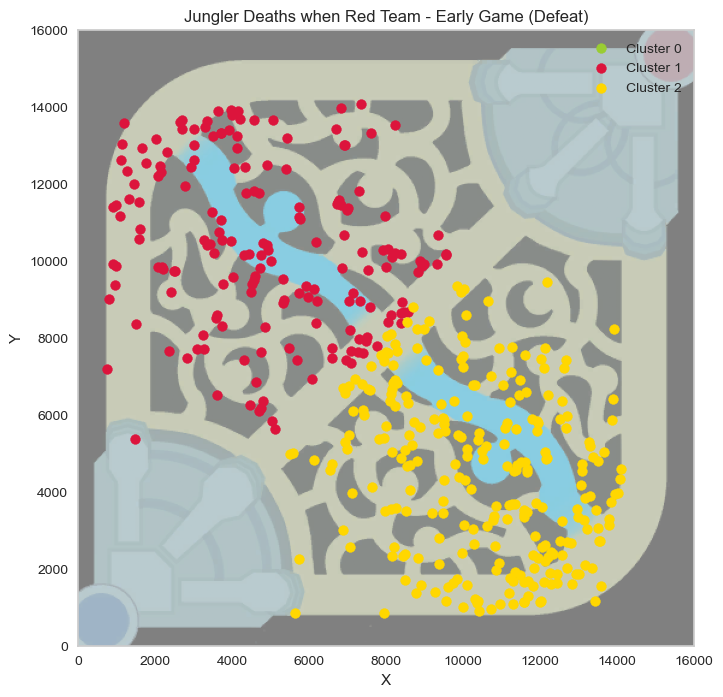

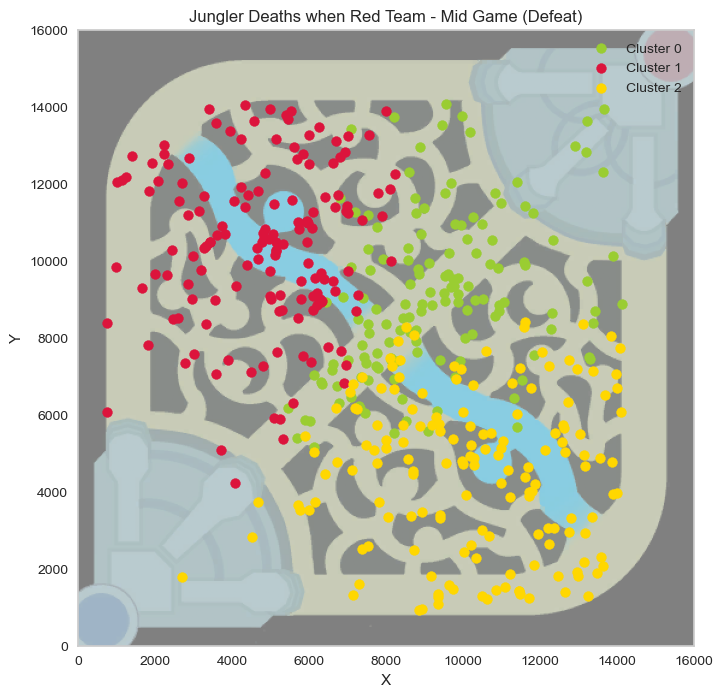

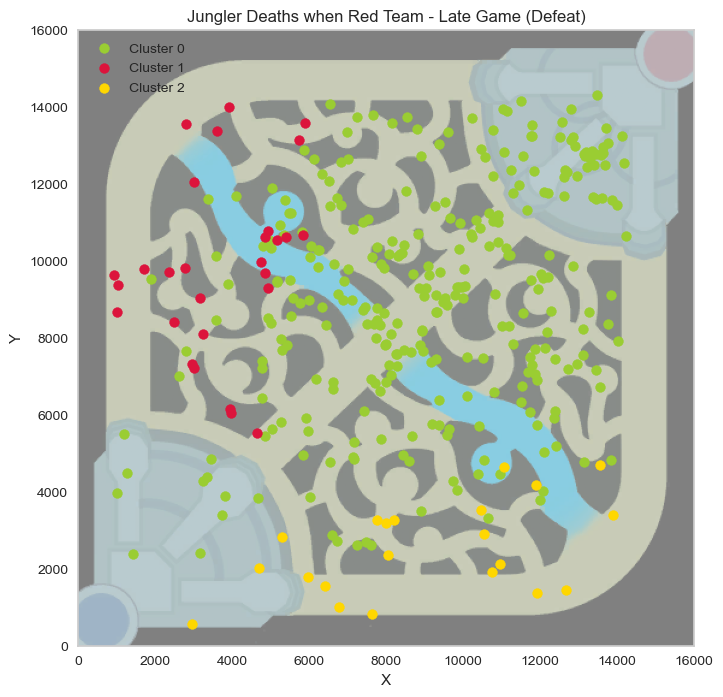

In [226]:
# Define time intervals (in minutess)
bins = [0, 13, 22, 45]
labels = ['Early Game', 'Mid Game', 'Late Game']

# Using existing DataFrame
profiling_df_red_defeat['time_phase'] = pd.cut(profiling_df_red_defeat['timestamp'], bins=bins, labels=labels, right=True)

# Set cluster colors
colors = ['yellowgreen', 'crimson', 'gold', 'cornflowerblue', 'purple']

# Plot three separate maps (one for each time phase)
for phase in labels:
    plt.figure(figsize=(8,8))
    plt.imshow(img, extent=[0, 16000, 0, 16000], alpha=0.5)

    for cluster_num in range(best_k):
        subset = profiling_df_red_defeat[
            (profiling_df_red_defeat['time_phase'] == phase) &
            (profiling_df_red_defeat['cluster'] == cluster_num)
        ]
        plt.scatter(subset['coordinate_x'], subset['coordinate_y'],
                    s=50, color=colors[cluster_num], label=f'Cluster {cluster_num}')

    plt.title(f"Jungler Deaths when Red Team - {phase} (Defeat)")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(False)
    plt.show()


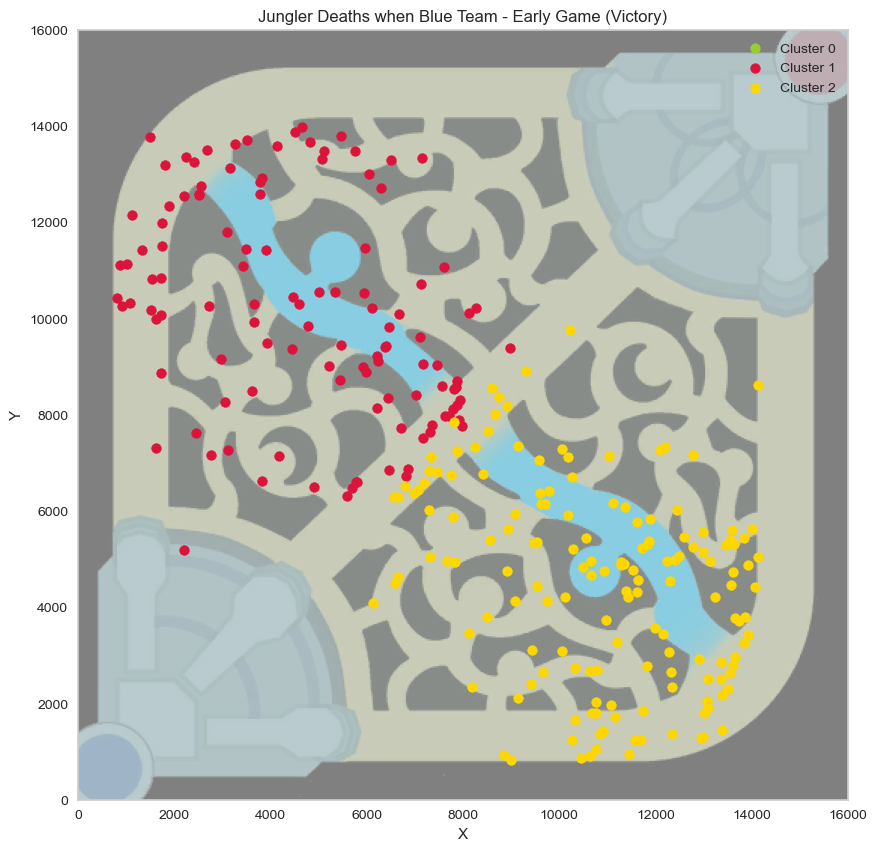

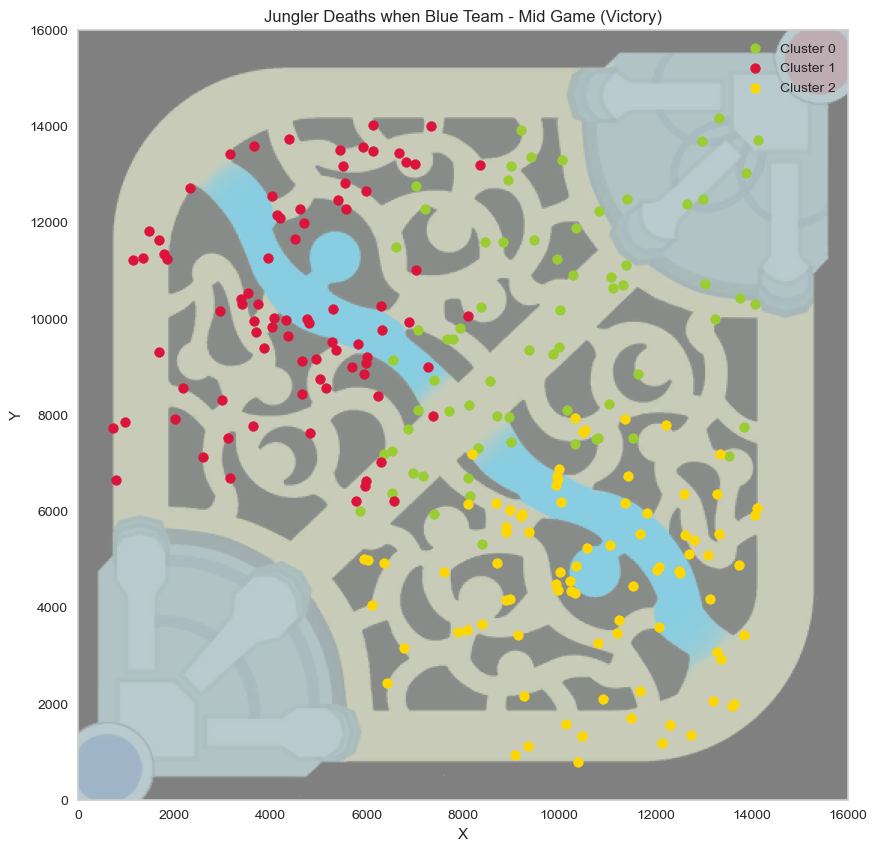

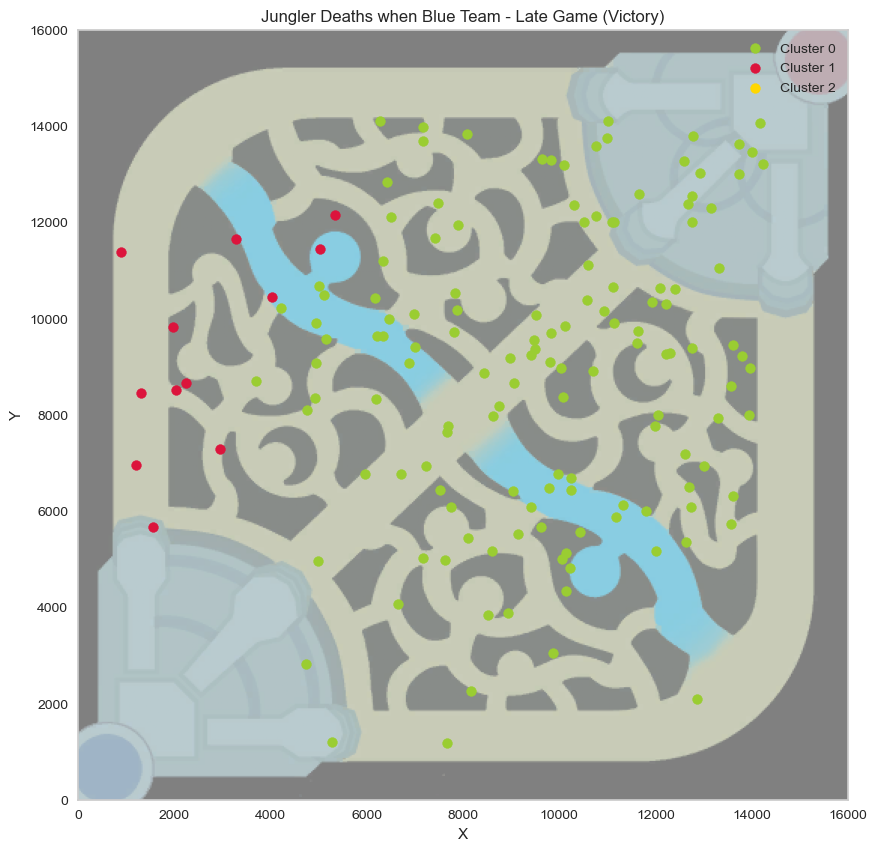

In [227]:
# Define time intervals (in minutess)
bins = [0, 13, 22, 45]
labels = ['Early Game', 'Mid Game', 'Late Game']

# Using existing DataFrame
profiling_df_blue_victory['time_phase'] = pd.cut(profiling_df_blue_victory['timestamp'], bins=bins, labels=labels, right=True)

# Set cluster colors
colors = ['yellowgreen', 'crimson', 'gold', 'cornflowerblue', 'purple']

# Plot three separate maps (one for each time phase)
for phase in labels:
    plt.figure(figsize=(10,10))
    plt.imshow(img, extent=[0, 16000, 0, 16000], alpha=0.5)

    for cluster_num in range(best_k): 
        subset = profiling_df_blue_victory[
            (profiling_df_blue_victory['time_phase'] == phase) &
            (profiling_df_blue_victory['cluster'] == cluster_num)
        ]
        plt.scatter(subset['coordinate_x'], subset['coordinate_y'],
                    s=50, color=colors[cluster_num], label=f'Cluster {cluster_num}')

    plt.title(f"Jungler Deaths when Blue Team - {phase} (Victory)")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(False)
    plt.show()

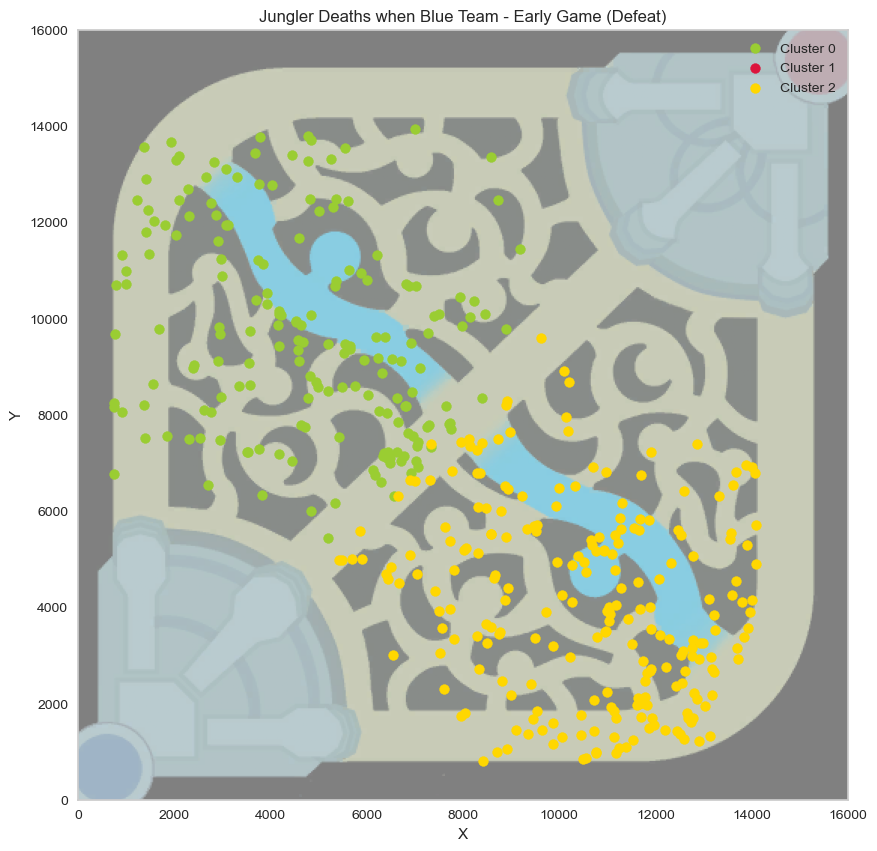

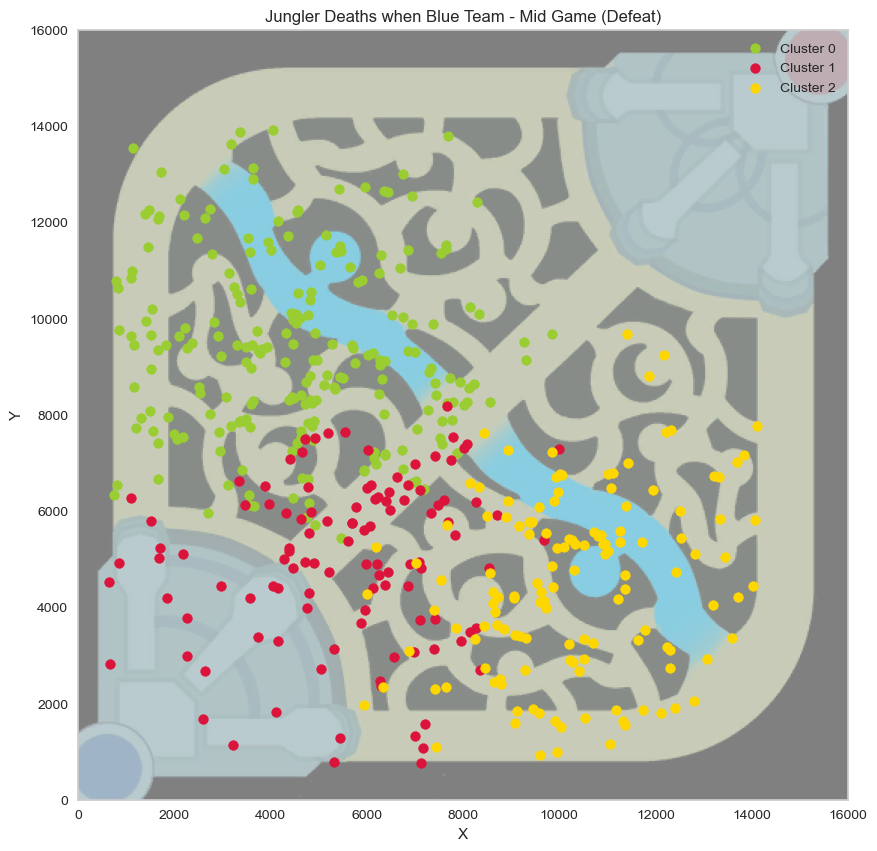

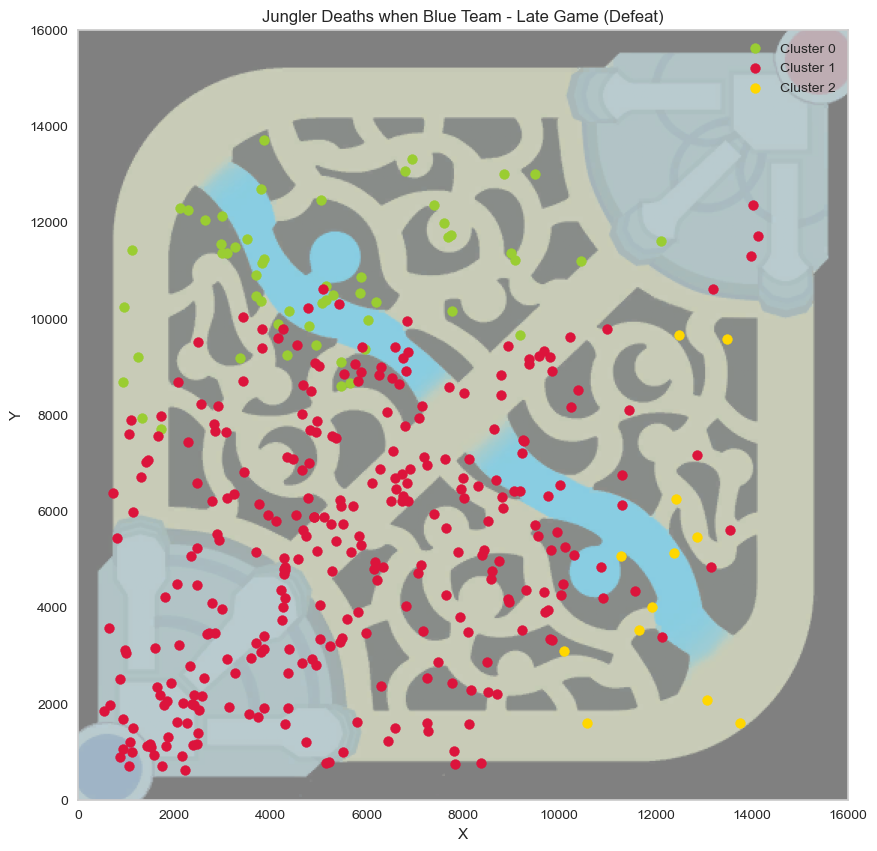

In [228]:
# Define time intervals (in minutess)
bins = [0, 13, 22, 45]
labels = ['Early Game', 'Mid Game', 'Late Game']

# Using existing DataFrame
profiling_df_blue_defeat['time_phase'] = pd.cut(profiling_df_blue_defeat['timestamp'], bins=bins, labels=labels, right=True)

# Set cluster colors
colors = ['yellowgreen', 'crimson', 'gold', 'cornflowerblue', 'purple']

# Plot three separate maps (one for each time phase)
for phase in labels:
    plt.figure(figsize=(10,10))
    plt.imshow(img, extent=[0, 16000, 0, 16000], alpha=0.5)

    for cluster_num in range(best_k):
        subset = profiling_df_blue_defeat[
            (profiling_df_blue_defeat['time_phase'] == phase) &
            (profiling_df_blue_defeat['cluster'] == cluster_num)
        ]
        plt.scatter(subset['coordinate_x'], subset['coordinate_y'],
                    s=50, color=colors[cluster_num], label=f'Cluster {cluster_num}')

    plt.title(f"Jungler Deaths when Blue Team - {phase} (Defeat)")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(False)
    plt.show()